<a href="https://colab.research.google.com/github/danionella/hoffmann_et_al_2023/blob/main/notebooks/generate_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [3]:
# this might take 5-10 minutes
!mamba  install  -q -y -c rapidsai -c conda-forge -c nvidia cucim cuml #cupy
!git clone https://github.com/danionella/hoffmann_et_al_2023.git
!pip install --ignore-installed  --quiet ./hoffmann_et_al_2023
!wget "https://owncloud.charite.de/owncloud/index.php/s/zc9NTVJMw8AiuQn/download?path=%2F&files=20230611_export_3.h5" -O data.h5

Preparing transaction: ...working... done
Verifying transaction: ...working... done


The following PRELINK MESSAGES are INCLUDED:


  File nvcomp.txt:

  By downloading and using the libcudf conda package, you accept the terms
  and conditions of the NVIDIA NVCOMP Software License Agreement:
    https://developer.download.nvidia.com/compute/nvcomp/2.3/LICENSE.txt


Executing transaction: ...working... By downloading and using the CUDA Toolkit conda packages, you accept the terms and conditions of the CUDA End User License Agreement (EULA): https://docs.nvidia.com/cuda/eula/index.html


By downloading and using the CubinLinker conda packages, you accept the terms and conditions of the CubinLinker License Agreement: https://docs.rapids.ai/licenses/CubinLinker.txt

done
Cloning into 'hoffmann_et_al_2023'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 156 (delta 74), reused 111 (de

# Analysis

## Run in any case

In [1]:
import h5py as h5
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import xarray as xr
import os
import matplotlib
import cupy as cp
from scipy.stats import pearsonr
from scipy.optimize import minimize
import seaborn as sns

from wholebrain import util,cluster,spatial,regression,stats

# set figure colors
c_voxel="#3B7BBF"
c_random='#F9A91C'
c_pca='#ED1B50'

# helper functions

def binfcn(x):
    return np.nanmean(x), np.quantile(x,0.05), np.quantile(x,0.95)

def load_dset(name):
    with h5.File('./data.h5','r') as fh5:
        return fh5[name]['coords'][:],fh5[name]['dff'][:],fh5[name]['traces'][:]

/usr/local/lib/python3.10/site-packages/cupy/_environment.py:445: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
/usr/local/lib/python3.10/site-packages/rmm/__init__.py:56: FutureWarning: Use of 'rmm.rmm_cupy_allocator' is deprecated and will be

In [2]:
data={}
with h5.File('./data.h5','r') as fh5:
    names=[n for n in fh5.keys()]
    print('Datasets:', names)

p_out='tmp'
os.makedirs(os.path.join('./',p_out),exist_ok=True)

Datasets: ['dset_0', 'dset_1', 'dset_2', 'dset_3', 'dset_4', 'dset_5']


## Figure 3
Note: this requires a GPU with at least 32 GB RAM (e.g. using the A100 GPU available on Colab Pro). The other figures can be computed with 16 GB RAM (compatible with the free version of Colab).

In [ ]:
pars={"corr_fc":
     { "min_dist":400,
      "radius_list": [5,10,15,25,50,100,150,200],
      "save_full_at":[5,50,100,200],
      "dec_factor":20}
     }

In [ ]:
name=names[0] #Select Dataset
coords,dff,traces=load_dset(name)
dff_mu=(dff-np.nanmean(dff,0,keepdims=True))[~np.isnan(dff.sum(1))] # Centered Data without NANs ( motion)

Compute pairwise correlations, pairwise distances and pairwise correlations of macro-voxels

In [ ]:

fh5_l = h5.File(os.path.join(p_out, f"{name}_correlations.h5"), "w")
cc = stats.corrx(cp.array(dff_mu,'single'), cp.array(dff_mu,'single'))
pd = spatial.pdist(cp.array(coords,'single'), None)
fh5_l["ipsi_cc"], fh5_l["contra_cc"] = util.neighbourhood_correlation(
    coords, cc.get())
fh5_l["cc"] = cc.get()
fh5_l["pd"] = pd.get()
del cc,pd


fh5_l["fc_before"], fh5_l["fc_corr_mean"], fh5_l["fc_after"] = util.corr_fc( fh5_l["cc"][:], fh5_l["pd"][:], cp.array(dff_mu,'single'), **pars["corr_fc"])
fh5_l.close()


Load data and compute histrogram values

In [ ]:
n_step=50
dist_bins = np.r_[10:1000:5]
binstats_list=[]

with h5.File(os.path.join(p_out, f"{name}_correlations.h5"),'r') as fh5:
    cc=fh5['cc'][:]
    pd=fh5['pd'][:]
    contra_cc=fh5['contra_cc'][:]
    ipsi_cc=fh5['ipsi_cc'][:]
    binstats = util.apply_to_bins(pd.ravel()[::n_step], dist_bins, cc.ravel()[::n_step], binfcn)
    binstats_list.append(binstats)
    print(fh5.keys())

100%|███████████████████████████████████████████████████████| 197/197 [00:00<00:00, 244.46it/s]

<KeysViewHDF5 ['cc', 'contra_cc', 'fc_after', 'fc_before', 'fc_corr_mean', 'ipsi_cc', 'pd']>


### Figure 3a

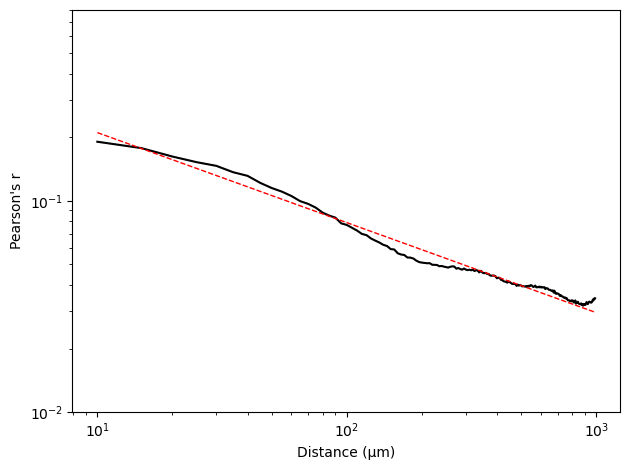

In [ ]:
fig, ax = plt.subplots()
bin_ar=np.array(binstats_list)[:,:,0]
for ii,binstats in enumerate(binstats_list):
        xx=dist_bins[: - 1]
        yy=binstats[:, 0]
        powlaw= lambda x,a,k: a*xx**(k)
        mse= lambda a: np.sum((powlaw(xx,a[0],a[1])-yy)**2)
        a=minimize(mse,[yy.max(),-1])
        ax.plot(xx, yy, label=names[ii],c='k',lw=1,alpha=0.2)
        ax.plot(xx, powlaw(xx,*a.x).squeeze(),'--',c='r',lw=0.5,label='fit',alpha=0.2)

powlaw= lambda x,a,k: a*xx**(k)
yy=bin_ar.mean(0)
ax.plot(xx,yy,c='k')
mse= lambda a: np.sum((powlaw(xx,a[0],a[1])-yy)**2)
a=minimize(mse,[yy.max(),-1])
ax.plot(xx, powlaw(xx,*a.x).squeeze(),'--',c='r',lw=1,label='fit')

    #ax.fill_between(dist_bins[1: - 1], binstats[1:, 1], binstats[1:, 2], label='5%-95%')
ax.set_ylim(0.01, 0.8)
#ax.set_xlim(None, 1500)
#ax.set_xticks((0,0.1,0.2,0.4))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Distance (µm)')
ax.set_ylabel("Pearson's r")
plt.tight_layout()


### Figure 3e

100%|████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.80s/it]


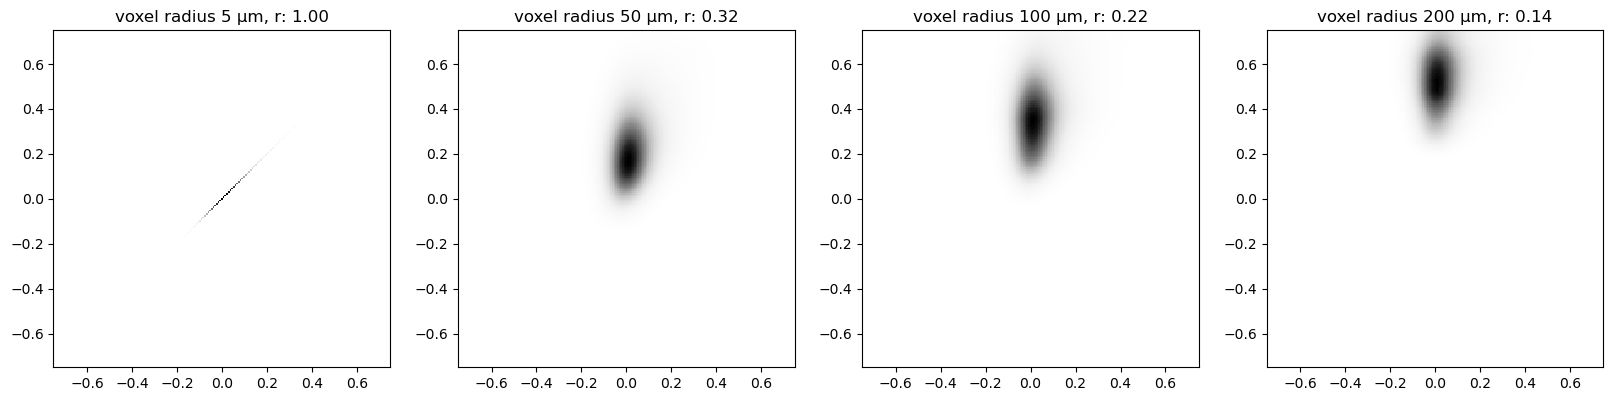

In [ ]:
fig,axi=plt.subplots(1,4,figsize=[20,20])
with h5.File(os.path.join(p_out, f"{name}_correlations.h5"),'r') as fh5:
    for ii, s in enumerate(tqdm(pars['corr_fc']['save_full_at'])):
        x=fh5['fc_after'][ii]
        y=fh5['fc_before']
        r = pearsonr(x[~np.isnan(x)],y[~np.isnan(x)])
        axi[ii].hist2d(y, x,  bins=np.linspace(-.75,.75,200), cmap='Greys',rasterized=True);
        axi[ii].set_aspect('equal', 'box')
        ix=pars['corr_fc']['radius_list'].index(s)
        r_lbl=fh5['fc_corr_mean'][ix,0]
        axi[ii].set_title(f'voxel radius {s} µm, r: {r_lbl:.2f}')


### Figure 3f

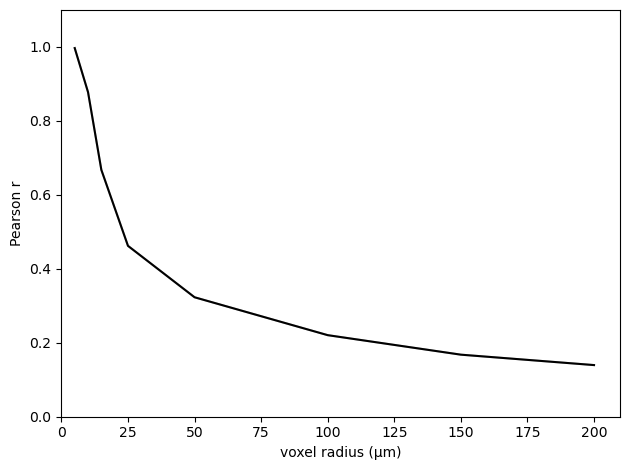

In [ ]:
fig,ax=plt.subplots()
fc_l=[]



with h5.File(os.path.join(p_out, f"{name}_correlations.h5"),'r') as fh5:
        _=ax.plot(pars["corr_fc"]["radius_list"],fh5['fc_corr_mean'],label=name,c='k',alpha=0.2)
        fc_l.append(fh5['fc_corr_mean'][:])
ax.plot(pars['corr_fc']['radius_list'],np.array(fc_l).mean(0),'k',ls='-')
_=ax.set(xlim=(0,None), ylim=(0,1.1), xlabel='voxel radius (µm)', ylabel='Pearson r')
plt.tight_layout()


## Figure 4

In [3]:
n_repeats=3
alpha_repeats=3

pars={"global": {"stripe_period":300,
                 "val_fraction":0.2,
                 "test_fraction":0.2,
                 "target_fraction":0.1,
                 "alphas":np.geomspace(1,10000,20).tolist(),
                "alpha_repeats":alpha_repeats
             },
 "pca_reg":
 { "dims_list":np.geomspace(1, 1500, 200).tolist(),"n_repeats":n_repeats},
 "random_predictors":
 { "n_pred_list": [100,200,400,1000,2000,5000,10000,20000],"n_repeats":n_repeats},
 "voxelate":
 {"s_bins_dim": [5,10,25,50,100,150,200,500],"n_pred_list": [100,200,400,1000,2000,5000,10000,20000],"n_repeats":n_repeats},
"r2_scan":{"s_bins":[5,10,25,50,100,150,200,500],"n_pred_list": [100,200,400,1000,2000,5000,10000,20000],"alphas":np.geomspace(1,10000,20).tolist(),"n_repeats":n_repeats},
     }

In [4]:
coords,dff,traces=load_dset(names[0]) #Choose dataset
dff_mu=(dff-np.nanmean(dff,0,keepdims=True))[~np.isnan(dff.sum(1)),:] # Centered Data without NANs ( motion)

In [5]:
cv_train,cv_val,cv_test=util.create_crossvalidation_mask(dff_mu)
n_targets = int(dff_mu.shape[1] * pars["global"]["target_fraction"])
max_npred=(1-pars['global']['target_fraction'])*dff_mu.shape[1]

### Figure 4b,c

#### Bi-crossvalidated PCA

In [6]:
r2_bcvpca = util.pca_run(dff_mu, cv_test + cv_train,pars["pca_reg"]["dims_list"],n_targets=n_targets, n_repeats=pars["pca_reg"]["n_repeats"],)


  0%|          | 0/3 [00:00<?, ?it/s]

#### Determination of regularization parameter for ridge regression

In [7]:
print("Alpha Scan for regression")

alphas=pars["global"]["alphas"]
r2_l=[]
s_bin=pars["voxelate"]["s_bins_dim"]

for alpha in alphas:
        nnz, r2_voxelate = util.voxelate_regression(
            [s_bin[len(s_bin)//2]],
            dff_mu,
            coords,
            cv_test,
            n_targets=n_targets,
            n_repeats=pars["global"]["alpha_repeats"],
            alpha=alpha,
        )
        r2_l.append(r2_voxelate.mean())

#Update global alpha parameter
pars["global"]["alpha"]=alphas[np.argmax(r2_l)]

Alpha Scan for regression


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### Voxelized regression with determined alpha parameter


In [8]:
nnz, r2_voxelate = util.voxelate_regression(
    pars["voxelate"]["s_bins_dim"],
    dff_mu,
    coords,
    cv_test + cv_train,
    n_targets=n_targets,
    n_repeats=pars["voxelate"]["n_repeats"],
    alpha=pars["global"]["alpha"],
)



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

#### Random predictors with determined alpha parameter

In [9]:

r2_rand_pred = util.ridge_random(
    dff_mu,
    pars["random_predictors"]["n_pred_list"],
    cv_test + cv_train,
    n_repeats=pars["random_predictors"]["n_repeats"],
    alpha=pars["global"]["alpha"],
    n_targets=n_targets,
)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

#### Figure panels

<ipython-input-10-87846f719b06>:25: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[1].set_xlim(0,None)


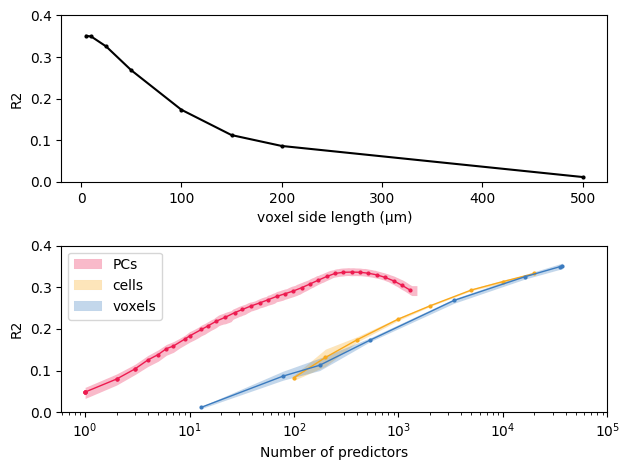

In [10]:
fig,ax=plt.subplots(2,1)
ms=2
lw=1
ax[0].plot(r2_voxelate.voxelsize,r2_voxelate.mean('n_repeats'), '-',color='k',marker='o',markersize=ms)
ax[0].set(xlabel='voxel side length (µm)', ylabel='R2')
ax[0].set_xticks(np.arange(0,600,100))
ax[0].set_ylim(0,0.4)
ax[1].plot(np.floor(r2_bcvpca.dimensions)[::5],r2_bcvpca.mean('n_repeats')[::5],color=c_pca,linestyle='-',marker='o',markersize=ms,alpha=1,lw=lw)
ax[1].fill_between(np.floor(r2_bcvpca.dimensions),r2_bcvpca.quantile(0.05,'n_repeats'),r2_bcvpca.quantile(0.95,'n_repeats'),alpha=0.3,color=c_pca,lw=0.01, label='PCs')


ax[1].plot(r2_rand_pred.n_predictors,r2_rand_pred.mean('n_repeats'),color=c_random,linestyle='-',marker='o',markersize=ms,alpha=1,lw=lw)
ax[1].fill_between(r2_rand_pred.n_predictors,r2_rand_pred.quantile(0.05,'n_repeats'),r2_rand_pred.quantile(0.95,'n_repeats'),alpha=0.3,color=c_random,lw=0.01, label='cells')

ax[1].plot(nnz.mean('n_repeats'),r2_voxelate.mean('n_repeats'),c=c_voxel,linestyle='-',marker='o',markersize=ms,alpha=1,lw=lw)
ax[1].fill_between(nnz.mean('n_repeats'),r2_voxelate.quantile(0.05,'n_repeats'),r2_voxelate.quantile(0.95,'n_repeats'),alpha=0.3,color=c_voxel,lw=0.01, label='voxels')


ax[1].set_xscale('log')
ax[1].set_xlabel('Number of predictors')
ax[1].set_ylabel('R2')
ax[1].legend()
ax[1].set_xticks([10**x for x in range(0,6)])
ax[1].set_ylim(0,0.4)
ax[1].set_xlim(0,None)
plt.tight_layout()

### Figure 4d

#### De-coupling R2 and voxelsize (Duration ~ 40 mins)

In [11]:
R2s = util.voxelate_alpha_scan(
        pars["r2_scan"]["s_bins"],
        pars["r2_scan"]["n_pred_list"],
        coords,
        dff_mu,
        cv_test,
        cv_train,
        pars["r2_scan"]["alphas"],
        n_repeats=pars["global"]["alpha_repeats"],
        n_targets=n_targets,
    )
alphas_max = R2s.mean("repeats").idxmax("alphas")

R2s_val, batch_id = util.voxelate_all(
    pars["r2_scan"]["s_bins"],
    pars["r2_scan"]["n_pred_list"],
    coords,
    dff_mu,
    cv_train + cv_test,
    alphas_max,
    n_repeats=pars["r2_scan"]["n_repeats"],
    n_targets=n_targets,
)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

#### Figure panel

<ipython-input-12-6fcf5a54d7b2>:23: RuntimeWarning: Mean of empty slice
  ax.plot(R2s_val.voxel_size,[np.nanmean(x) for x in vox_list],ls='-',c=color,label=f'{int(nn)}')
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
<ipython-input-12-6fcf5a54d7b2>:40: RuntimeWarning: Mean of empty slice
  ax.plot(R2s_val.voxel_size,[np.nanmean(x) for x in vox_list],ls='--',c=color, label='')
<ipython-input-12-6fcf5a54d7b2>:43: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string " " (-> linestyle=' '). The keyword argument will take precedence.
  plt.plot([], [],' ',ls='--', label="shuffled")


[Text(0.5, 0, 'voxel side length (µm)'), Text(0, 0.5, 'R2')]

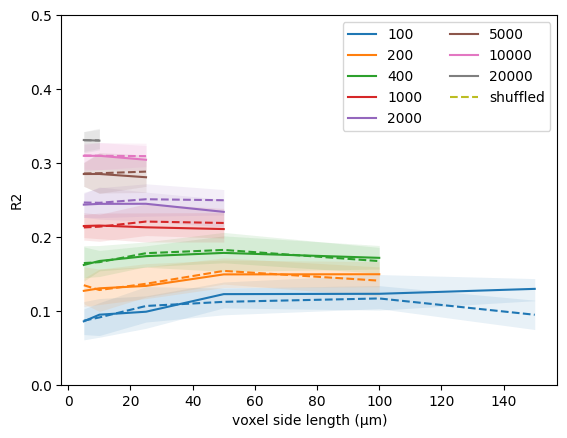

In [12]:
##### R2 Plot


opac=0.1
var=xr.DataArray(dff_mu[cv_val].var(0),dims='cells')
fig,ax=plt.subplots()
for nn in R2s_val.num_predictors:
    color = next(ax._get_lines.prop_cycler)['color']
    vox_list=[]
    for vx_sz in R2s_val.voxel_size:
        batch_means=[]
        for irep in R2s_val.repeats:
            arr=batch_id[0].sel(num_predictors=nn).isel(repeats=irep).sel(voxel_size=vx_sz)
            arr_r2=R2s_val[0].sel(num_predictors=nn).isel(repeats=irep).sel(voxel_size=vx_sz)

            batch_nr,indx=np.unique(arr,return_inverse=True)

            for ii in range(max(indx)):
                batch_mask=(indx==ii)
                batch_means.append(np.average(arr_r2[batch_mask],weights=var[batch_mask]))
        vox_list.append(batch_means)

    ax.plot(R2s_val.voxel_size,[np.nanmean(x) for x in vox_list],ls='-',c=color,label=f'{int(nn)}')
    ax.fill_between(R2s_val.voxel_size,[np.nanpercentile(x,95) for x in vox_list],[np.nanpercentile(x,5) for x in vox_list],alpha=opac,color=color,lw=0.01)

    vox_list=[]
    for vx_sz in R2s_val.voxel_size:
        batch_means=[]
        for irep in R2s_val.repeats:
            arr=batch_id[1].sel(num_predictors=nn).isel(repeats=irep).sel(voxel_size=vx_sz)
            arr_r2=R2s_val[1].sel(num_predictors=nn).isel(repeats=irep).sel(voxel_size=vx_sz)

            batch_nr,indx=np.unique(arr,return_inverse=True)

            for ii in range(max(indx)):
                batch_mask=(indx==ii)
                batch_means.append(np.average(arr_r2[batch_mask],weights=var[batch_mask]))
        vox_list.append(batch_means)

    ax.plot(R2s_val.voxel_size,[np.nanmean(x) for x in vox_list],ls='--',c=color, label='')
    ax.fill_between(R2s_val.voxel_size,[np.nanpercentile(x,95) for x in vox_list],[np.nanpercentile(x,5) for x in vox_list],alpha=opac,color=color,lw=0.01)#,hatch="*")
ax.set_ylim(0,0.5)
plt.plot([], [],' ',ls='--', label="shuffled")
ax.legend(ncol=2,loc='upper right')
ax.set(xlabel='voxel side length (µm)', ylabel='R2')

## Figure 5

In [13]:
n_repeats = 25
pred_list = [50,100,200,400,1000,2000]
voxel_size_list = [50,100,200]
metrics = ['similarity', 'distortion']

out = np.ones((len(names), len(metrics), len(pred_list), len(voxel_size_list), n_repeats, 2)) * np.nan

for k_ds, name in enumerate(tqdm(names, position=0, leave=True)):

    coords,dff,traces=load_dset(name)
    dff_mu=(dff-np.nanmean(dff,0,keepdims=True))[~np.isnan(dff.sum(1))] # Centered Data without NANs ( motion)


    randperm = np.random.permutation(np.arange(len(coords)))
    dff_mu = dff_mu[:,randperm]
    coords = coords[randperm]


    cell_mask = np.zeros(len(coords), dtype='bool')
    cell_mask[::2] = True

    for k_metric, metric in enumerate(metrics):
        if metric == 'similarity':
            def distortion_stress(D0, D):
                return stats.pearsonr.gpu(D0.ravel(),D.ravel())[0]
            def distance_fun(x):
                return 1-stats.corrx.gpu(x.T,x.T)
        elif metric == 'distortion':
            def distortion_stress(D0, D):
                return spatial.distortion_stress(D0,D)
            def distance_fun(x):
                return spatial.pdist.gpu(x)

        D0 = distance_fun(dff_mu[:,cell_mask])

        for k_vx, voxel_size in enumerate(voxel_size_list):
            for k_pred, n_pred in enumerate(pred_list):
                for k in range(n_repeats):
                    cell_sub = dff_mu[:,np.random.choice(np.where(~cell_mask)[0], size=n_pred, replace=False)]
                    dd_cell = distortion_stress(D0,distance_fun(cell_sub))
                    vox_sub = spatial.voxelate(coords[~cell_mask] + np.random.rand(1,3)*voxel_size, dff_mu[:,~cell_mask], voxel_size, average=True)[0]
                    if vox_sub.shape[1] < n_pred: continue
                    vox_sub = vox_sub[:,np.random.choice(np.arange(vox_sub.shape[1]), size=n_pred, replace=False)]
                    dd_vox = distortion_stress(D0,distance_fun(vox_sub))
                    out[k_ds,k_metric,k_pred,k_vx,k,:] = [dd_cell, dd_vox]



  0%|          | 0/6 [00:00<?, ?it/s]

(-0.5906639499614411,
 1.0349392632478638,
 -0.9646840142622274,
 0.5736122726850303)

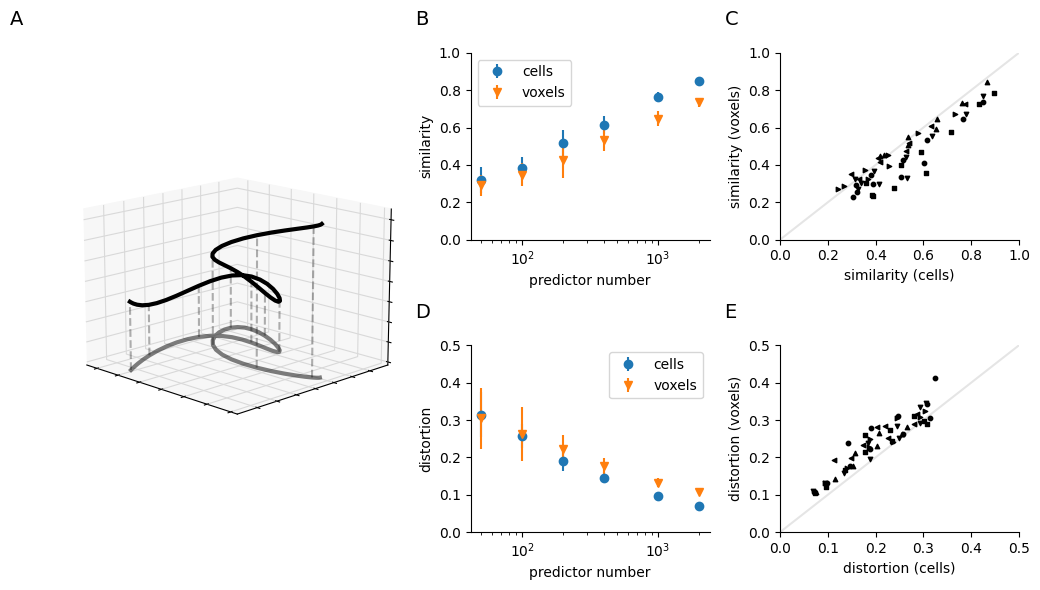

In [14]:
fig, axs = plt.subplot_mosaic("ABC;ADE", figsize=(10.5,6), width_ratios=[1.4,1,1])

trans = matplotlib.transforms.ScaledTranslation(-40/72, 20/72, fig.dpi_scale_trans)
for n, (key, ax) in enumerate(axs.items()):
    ax.text(0, 1, key, transform=ax.transAxes+trans, size=14, weight='regular')
sns.despine()

markers = ['o','v','^','<','>','s','*','+','x']

[axs[k].axis('off') for k in axs.keys() if k in ['A',]]

ylim = 1
axs['B'].errorbar(pred_list,out.mean(-2)[0,0,:,0,0], out.std(-2)[0,0,:,0,0],fmt='o', label='cells')
axs['B'].errorbar(pred_list,out.mean(-2)[0,0,:,0,1], out.std(-2)[0,0,:,0,1],fmt='v', label='voxels')
axs['B'].set(ylim=(0,ylim), xlabel='predictor number', ylabel=metrics[0], xscale='log')
axs['B'].legend()
for i in range(len(out)):
     axs['C'].scatter(out.mean(-2)[i,0,...,0].ravel(), out.mean(-2)[i,0,...,1], marker=markers[i], color='k', s=10)
axs['C'].plot([0,ylim],[0,ylim], 'k', alpha=0.1)
axs['C'].set(xlim=(0,ylim), ylim=(0,ylim), xlabel=metrics[0]+' (cells)', ylabel=metrics[0]+' (voxels)')

ylim = 0.5
axs['D'].errorbar(pred_list,out.mean(-2)[0,1,:,0,0], out.std(-2)[0,1,:,0,0],fmt='o', label='cells')
axs['D'].errorbar(pred_list,out.mean(-2)[0,1,:,0,1], out.std(-2)[0,1,:,0,1],fmt='v', label='voxels')
axs['D'].set(ylim=(0,ylim), xlabel='predictor number', ylabel=metrics[1], xscale='log')
axs['D'].legend()
for i in range(len(out)):
     axs['E'].scatter(out.mean(-2)[i,1,...,0].ravel(), out.mean(-2)[i,1,...,1],  marker=markers[i], color='k', s=10)
axs['E'].plot([0,ylim],[0,ylim], 'k', alpha=0.1)
axs['E'].set(xlim=(0,ylim), ylim=(0,ylim), xlabel=metrics[1]+' (cells)', ylabel=metrics[1]+' (voxels)')

fig.tight_layout()

import scipy
ss = axs['A'].get_subplotspec()
axs['A'] = fig.add_subplot(ss, projection='3d')
seed = 185 #np.random.randint(1000)
np.random.seed(seed)
r = np.random.randn(50,3)*2
rf = scipy.ndimage.gaussian_filter1d(r, 5, axis=0)
rf -= rf.mean(0)
axs['A'].plot(rf[:,0], rf[:,1], rf[:,2], 'k', linewidth=3)
axs['A'].plot(rf[:,0], rf[:,1], 'k', zs=-1, zdir='z', linewidth=3, alpha=0.5)
for i in range(0,len(rf),5):
    axs['A'].plot([rf[i,0], rf[i,0]], [rf[i,1], rf[i,1]], [-1, rf[i,2]], 'k--', alpha=0.3, linewidth=1.5)

for axis in [axs['A'].xaxis, axs['A'].yaxis, axs['A'].zaxis]:
    axis.set_ticklabels([])
    axis._axinfo['grid']['color'] = np.ones(3)*0.85
    axis.set_pane_color(np.ones(3)*0.97)

axs['A'].view_init(elev=15, azim=-45, roll=0)
axs['A'].axis('tight')